In [1]:
import litebird_sim as lbs
import numpy as np
import healpy as hp
from dataclasses import asdict
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [29]:
nside = 64
mission_time_is_sec = 200*24*3600
instrument = "MFT"
channel = "M1-100"
sampling = 1 # this replaces channelinfo.sampling_rate_hz

In [30]:
imo = lbs.Imo()
sim = lbs.Simulation(base_path="./tutorial",
                     start_time=0,
                     duration_s=mission_time_is_sec,
                    )

In [31]:
mft_file = sim.imo.query("/releases/v1.0/satellite/"+instrument+"/instrument_info")
sim.generate_spin2ecl_quaternions(imo_url="/releases/v1.0/satellite/scanning_parameters/")
instrumentinfo = lbs.InstrumentInfo(name=instrument, 
    boresight_rotangle_rad=np.deg2rad(mft_file.metadata["boresight_rotangle_deg"]),
    spin_boresight_angle_rad=np.deg2rad(mft_file.metadata["spin_boresight_angle_deg"]),
    spin_rotangle_rad=np.deg2rad(mft_file.metadata["spin_rotangle_deg"]),
    )
channelinfo = lbs.FreqChannelInfo.from_imo(
    url="/releases/v1.0/satellite/"+instrument+"/"+channel+"/channel_info",
    imo=imo,
    )
hwp_radpsec = mft_file.metadata["hwp_rpm"]*2.0*np.pi/60.0

In [32]:
dets=[]
detquats=[]
#for detname in channelinfo.detector_names[0:20]:
for detname in ('M03_030_QA_100T','M03_030_QA_100B'): #we choose the couple of detector at the MFT boresight
    det=lbs.DetectorInfo.from_imo(
        url="/releases/v1.0/satellite/"+instrument+"/"+channel+"/"+detname+"/detector_info",
        imo=imo,
    )
    det.sampling_rate_hz = sampling
    dets.append(det)
    detquats.append(det.quat)

## Create file with HWP non-ideal parameters for MFT
#### The files 'M/HFT_Mesh_HWP_v2.txt' are given from the simulated HWP profiles at https://wiki.kek.jp/download/attachments/123338913/2019_06_22_MFT_HFT_HWP_GP_to_LB_team.xlsx?version=1&modificationDate=1585750021431&api=v2. We read the MFT one to convert the parameters in the way defined in Giardiello et al.

In [6]:
mft = np.loadtxt('MFT_Mesh_HWP_v2.txt')     

nu = mft[:,0]
h1 = np.sqrt(mft[:,1]) - 1.
h2 = np.sqrt(mft[:,3]) - 1.
beta  = mft[:,5] - 180.
z1 = 0.01*np.ones_like(nu) 
z2 = 0.01*np.ones_like(nu)

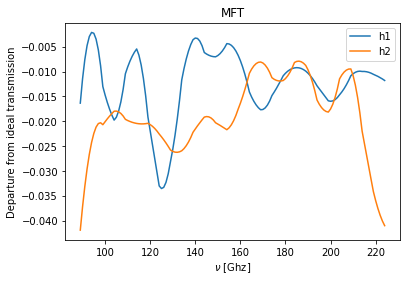

In [7]:
plt.plot(nu,h1,label='h1')
plt.plot(nu,h2,label='h2')
plt.xlabel(r'$\nu$ [Ghz]')
plt.ylabel('Departure from ideal transmission')
plt.title('MFT')
plt.legend()

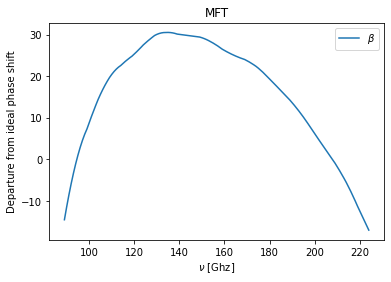

In [8]:
plt.plot(nu,beta,label=r'$\beta$')
plt.xlabel(r'$\nu$ [Ghz]')
plt.ylabel('Departure from ideal phase shift')
plt.title('MFT')
plt.legend()

for the purpose of this exercise, let's focus on the frequencies of the 100 GHz band (89,111)

In [7]:
i_i = np.where(nu == 89)[0][0]
i_f = np.where(nu == 111)[0][0]
Nu=nu[i_i:i_f]
H1=h1[i_i:i_f]
H2=h2[i_i:i_f]
Beta=beta[i_i:i_f]
Z1=z1[i_i:i_f]
Z2=z2[i_i:i_f]

In [10]:
np.savetxt('MFT_100_h_beta_z.txt', np.column_stack((Nu,H1,H2,Beta,Z1,Z2))) 

Our code assumes we also have an header, let's write it:

In [8]:
header = '# nu   h1   h2   beta   z1   z2'
file = open('MFT_100_h_beta_z.txt', 'r')
lines = [line for line in file]
file.close()
file = open('MFT_100_h_beta_z.txt', 'w')
# Rewrite the file: append header if needed, and all lines which previously were there
# excluding any misplaced header lines which were not at row 1
file.write(header + '\n')
file.write(''.join([line for line in lines]))
file.close()

In [9]:
par = { 'hwp_sys':
       {'band_filename': 'MFT_100_h_beta_z.txt',
        'band_filename_solver': 'MFT_100_h_beta_z.txt',  #same as tod parameters
       }
      }

## Fill tod with a band top-hat + wings

In [10]:
obs_w, = sim.create_observations(detectors=dets)

pointings = lbs.scanning.get_pointings(obs_w,
                                       spin2ecliptic_quats=sim.spin2ecliptic_quats,
                                       detector_quats=detquats,
                                       bore2spin_quat=instrumentinfo.bore2spin_quat,
                                      )

if you are using band integration (`integrate_in_band = True` in `hwp_sys.set_parameters`) you don't need to create a map beforehand, the `set_parameters` function of HwpSys will generate one cmb+fg map for each frequency. The following cell is commented because it is not needed when using band integration

In [12]:
#Mbsparams = lbs.MbsParameters(make_cmb =True,
#                              make_fg = False,
#                              gaussian_smooth = True,
#                              bandpass_int = False,
#                              nside = nside,
#                             )

#mbs = lbs.Mbs(simulation=sim,
#              parameters=Mbsparams,
#              channel_list=channelinfo,
#             )
#maps = mbs.run_all()[0][channel]

[2021-12-30 12:21:37,845 INFO MPI#0000] generating and saving cmb simulations
[2021-12-30 12:21:37,863 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2021-12-30 12:21:38,077 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 12:21:38,077 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from tutorial/cmb/0000/cmb_0000_date_211230.fits
  warnings.warn(f"Access data from {full_path}")
[2021-12-30 12:21:38,960 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2021-12-30 12:21:38,963 INFO MPI#0000] NSIDE = 512
[2021-12-30 12:21:38,963 INFO MPI#0000] ORDERING = RING in fits file
[2021-12-30 12:21:38,964 INFO MPI#0000] INDXSCHM = IMPLICIT


***************** D
***************** D
***************** D


[2021-12-30 12:21:39,725 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2021-12-30 12:21:44,631 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2021-12-30 12:21:44,632 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2021-12-30 12:21:44,676 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 12:21:44,676 INFO MPI#0000] -> fwhm is 0.000000 arcmin


In [11]:
sim.parameter_file = par   #setting the parameter file
hwp_sys_band = lbs.HwpSysAndBandpass(sim)

Text(0, 0.5, 'transmission')

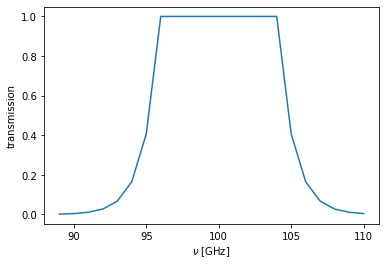

In [12]:
bandpass_parameters={'low edge': 96,'high edge': 104,'alpha': 0.9}
transmission=lbs.out_of_band_analysis.out_of_band_analysis.decaying_bandpass(Nu,
                                        bandpass_parameters['low edge'],
                                        bandpass_parameters['high edge'],
                                           bandpass_parameters['alpha'])
plt.plot(Nu,transmission)
plt.xlabel(r'$\nu$ [GHz]')
plt.ylabel('transmission')

Let's initialise Mbsparams in order to set a seed for the cmb map. The FG is always the same

In [10]:
Mbsparams = lbs.MbsParameters(
                make_cmb=True,
                make_fg=True,
                fg_models = ["pysm_synch_0", "pysm_freefree_1", "pysm_dust_0"],
                bandpass_int=True,
                maps_in_ecliptic=True,
                seed_cmb = 1234,
                nside = nside
            )

the next command will take a while with band integration, since it has to generate one map per frequency

In [14]:
hwp_sys_band.set_parameters(#maps=maps,    # ---> to use without band integration
                       integrate_in_band=True,
                       correct_in_solver=True,
                       built_map_on_the_fly=False,
                       nside=nside,
                       bandpass_parameters={'low edge': 96,
                                            'high edge': 104,'alpha': 0.9}, #a fake band smaller than the 
    #100GHz one, in order to generate less maps
                       include_beam_throughput=True,
                       Mbsparams = Mbsparams,
                      Channel = channelinfo
                      )

[2022-03-08 11:06:20,824 INFO MPI#0000] using the passed instrument to generate maps
[2022-03-08 11:06:20,825 INFO MPI#0000] generating and saving cmb simulations
[2022-03-08 11:06:20,840 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-03-08 11:06:20,844 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-03-08 11:06:20,845 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from tutorial/cmb/0000/cmb_0000_date_220308.fits
  warnings.warn(f"Access data from {full_path}")
[2022-03-08 11:06:20,893 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-03-08 11:06:20,896 INFO MPI#0000] NSIDE = 64
[2022-03-08 11:06:20,896 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-08 11:06:20,897 INFO MPI#0000] INDXSC

***************** D
***************** D
***************** D


/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-03-08 11:06:21,086 INFO MPI#0000] NSIDE = 512
[2022-03-08 11:06:21,087 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-08 11:06:21,089 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-03-08 11:06:21,217 INFO MPI#0000] NSIDE = 512
[2022-03-08 11:06:21,217 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-08 11:06:21,218 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_u_new.fits (if not c

In [15]:
t_in = time.time()
hwp_sys_band.fill_tod(obs_w,pointings,hwp_radpsec)
t_tod = time.time()
t_tod-t_in
#obs.tod *= 2.0  #this 2 factor is useful only when comparing to the mapmaking in lbs.make_bin_map
#for which the tod is twice as the one computed here

1.136826753616333

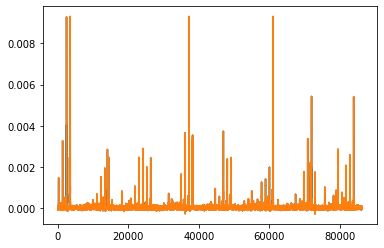

In [16]:
plt.plot(obs_w.tod[0,:100000])
plt.plot(obs_w.tod[1,:100000])

since we have few days of observation, it is pointless to generate a map

# Testing out_of_band_analysis against hwp_sys

Let's take now a top-hat band. Let's consider the actual 100 GHz one, in order to compare the result coming from out_of_band_analysis.py to the top-hat band that hwp_sys.py would consider by reading the frequencies in the parameter file `MFT_100_h_beta_z.txt`

Text(0, 0.5, 'transmission')

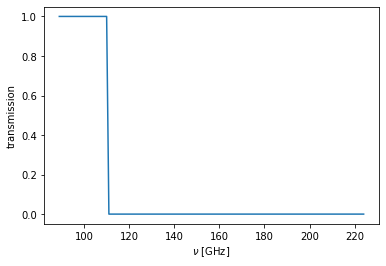

In [17]:
bandpass_parameters={'low edge': Nu[0],'high edge': Nu[-1]}
transmission=lbs.out_of_band_analysis.out_of_band_analysis.top_hat_bandpass(nu,
                                        bandpass_parameters['low edge'],
                                        bandpass_parameters['high edge'])
plt.plot(nu,transmission)
plt.xlabel(r'$\nu$ [GHz]')
plt.ylabel('transmission')

we generate a clean observation each time we want to compute a new tod

In [11]:
obs, = sim.create_observations(detectors=dets)

pointings = lbs.scanning.get_pointings(obs,
                                       spin2ecliptic_quats=sim.spin2ecliptic_quats,
                                       detector_quats=detquats,
                                       bore2spin_quat=instrumentinfo.bore2spin_quat,
                                      )

In [12]:
sim.parameter_file = par   #setting the parameter file
hwp_sys_band = lbs.HwpSysAndBandpass(sim)

In [13]:
hwp_sys_band.set_parameters(#maps=maps,    # ---> to use without band integration
                       integrate_in_band=True,
                       correct_in_solver=True,
                       built_map_on_the_fly=False,
                       nside=nside,
                       bandpass_parameters={'low edge': Nu[0],
                                            'high edge': Nu[-1]}, #100GHz band
                       include_beam_throughput=False,
                       Mbsparams = Mbsparams,
                       Channel = channelinfo
                      )

[2022-03-08 11:55:49,183 INFO MPI#0000] using the passed instrument to generate maps
[2022-03-08 11:55:49,184 INFO MPI#0000] generating and saving cmb simulations
[2022-03-08 11:55:49,197 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-03-08 11:55:49,201 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-03-08 11:55:49,201 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from tutorial/cmb/0000/cmb_0000_date_220308.fits
  warnings.warn(f"Access data from {full_path}")
[2022-03-08 11:55:49,238 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-03-08 11:55:49,240 INFO MPI#0000] NSIDE = 64
[2022-03-08 11:55:49,241 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-08 11:55:49,242 INFO MPI#0000] INDXSC

***************** D
***************** D
***************** D


[2022-03-08 11:55:49,421 INFO MPI#0000] NSIDE = 512
[2022-03-08 11:55:49,421 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-08 11:55:49,422 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-03-08 11:55:49,548 INFO MPI#0000] NSIDE = 512
[2022-03-08 11:55:49,548 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-08 11:55:49,549 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-03-08 11:55:49,667 INFO MPI#0000] NSIDE = 512
[2022-03-08 11:55:49,668 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-08 11:55:49,669 INFO MPI

In [14]:
hwp_sys_band.fill_tod(obs,pointings,hwp_radpsec)

In [15]:
obs.tod

array([[3.8648595e-05, 3.9065355e-05, 3.8842591e-05, ..., 3.9572496e-05,
        3.8385740e-05, 4.0520688e-05],
       [3.9318311e-05, 3.8736445e-05, 3.8108301e-05, ..., 3.8495233e-05,
        4.0655155e-05, 3.8177950e-05]], dtype=float32)

let's create a new simulation, initialise hwp_sys and compute the same kind of tod

In [16]:
sim1 = lbs.Simulation(base_path="./tutorial",
                     start_time=0,
                     duration_s=mission_time_is_sec,
                    )

In [17]:
mft_file = sim1.imo.query("/releases/v1.0/satellite/"+instrument+"/instrument_info")
sim1.generate_spin2ecl_quaternions(imo_url="/releases/v1.0/satellite/scanning_parameters/")

In [18]:
obs1, = sim1.create_observations(detectors=dets)

pointings1 = lbs.scanning.get_pointings(obs1,
                                       spin2ecliptic_quats=sim1.spin2ecliptic_quats,
                                       detector_quats=detquats,
                                       bore2spin_quat=instrumentinfo.bore2spin_quat,
                                      )

In [19]:
sim1.parameter_file = par
hwp_sys = lbs.HwpSys(sim1)

In [20]:
hwp_sys.set_parameters(#maps=maps,    # ---> to use without band integration
                       integrate_in_band=True,
                       correct_in_solver=True,
                       built_map_on_the_fly=False,
                       nside=nside,
                        Mbsparams = Mbsparams,
                      Channel = channelinfo
                      )

[2022-03-08 11:55:59,019 INFO MPI#0000] using the passed instrument to generate maps
[2022-03-08 11:55:59,021 INFO MPI#0000] generating and saving cmb simulations
[2022-03-08 11:55:59,033 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-03-08 11:55:59,038 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-03-08 11:55:59,039 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from tutorial/cmb/0000/cmb_0000_date_220308.fits
  warnings.warn(f"Access data from {full_path}")
[2022-03-08 11:55:59,072 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-03-08 11:55:59,075 INFO MPI#0000] NSIDE = 64
[2022-03-08 11:55:59,083 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-08 11:55:59,083 INFO MPI#0000] INDXSC

***************** D
***************** D
***************** D


[2022-03-08 11:55:59,248 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-08 11:55:59,250 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-03-08 11:55:59,373 INFO MPI#0000] NSIDE = 512
[2022-03-08 11:55:59,374 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-08 11:55:59,374 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-03-08 11:55:59,490 INFO MPI#0000] NSIDE = 512
[2022-03-08 11:55:59,491 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-08 11:55:59,491 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/

we see that the maps generated by the two classes are exactly the same

In [21]:
hwp_sys.maps == hwp_sys_band.maps

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       ...,

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        

In [22]:
hwp_sys.fill_tod(obs1,pointings1,hwp_radpsec)

The bands are the same

In [23]:
hwp_sys.cmb2bb/hwp_sys.norm == hwp_sys_band.cmb2bb

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [25]:
obs1.tod - obs.tod

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [26]:
obs.tod == obs1.tod

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

the two tod are exactly the same when we set `include_beam_throughput=False` in `hwp_sys_band.set_parameters`

## Introducing a shift to the bands

We can set the steps for generating tods including bands that have some shifts (we can both set a rigid shift of the two ends of the band and shift them differently).

In [71]:
obs_sh, = sim.create_observations(detectors=dets)
sim.parameter_file = par   #setting the parameter file
hwp_sys_band = lbs.HwpSysAndBandpass(sim)

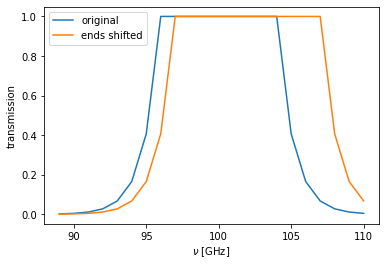

In [72]:
shift_low = 1  #needed resolution of 1 GHz since this is the present resolution on HWP parameters
shift_high = 3
bandpass_parameters={'low edge': 96,'high edge': 104,'alpha': 0.9}
transmission=lbs.out_of_band_analysis.out_of_band_analysis.decaying_bandpass(Nu,
                                        bandpass_parameters['low edge'],
                                        bandpass_parameters['high edge'],
                                           bandpass_parameters['alpha'])
transmission_shifted=lbs.out_of_band_analysis.out_of_band_analysis.decaying_bandpass(Nu,
                                        bandpass_parameters['low edge']+shift_low,
                                        bandpass_parameters['high edge']+shift_high,
                                           bandpass_parameters['alpha'])
plt.plot(Nu,transmission,label = 'original')
plt.plot(Nu,transmission_shifted,label = 'ends shifted')
plt.xlabel(r'$\nu$ [GHz]')
plt.ylabel('transmission')
plt.legend()

In [73]:
hwp_sys_band.set_parameters(#maps=maps,    # ---> to use without band integration
                       integrate_in_band=True,
                       correct_in_solver=True,
                       built_map_on_the_fly=False,
                       nside=nside,
                       bandpass_parameters={'low edge': 96+shift_low,
                                            'high edge': 104+shift_high,'alpha': 0.9}, #100GHz band
                       include_beam_throughput=True,
                       Mbsparams = Mbsparams
                      )

[2022-02-28 11:37:02,952 INFO MPI#0000] using the passed instrument to generate maps
[2022-02-28 11:37:02,955 INFO MPI#0000] generating and saving cmb simulations
[2022-02-28 11:37:02,968 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-02-28 11:37:02,973 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-02-28 11:37:02,974 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from tutorial/cmb/0000/cmb_0000_date_220228.fits
  warnings.warn(f"Access data from {full_path}")
[2022-02-28 11:37:03,002 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-02-28 11:37:03,005 INFO MPI#0000] NSIDE = 64
[2022-02-28 11:37:03,005 INFO MPI#0000] ORDERING = RING in fits file
[2022-02-28 11:37:03,006 INFO MPI#0000] INDXSC

***************** D
***************** D
***************** D


/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-02-28 11:37:03,285 INFO MPI#0000] NSIDE = 512
[2022-02-28 11:37:03,285 INFO MPI#0000] ORDERING = RING in fits file
[2022-02-28 11:37:03,286 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-02-28 11:37:03,409 INFO MPI#0000] NSIDE = 512
[2022-02-28 11:37:03,409 INFO MPI#0000] ORDERING = RING in fits file
[2022-02-28 11:37:03,410 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/ff_t_new.fits (if not cach

In [74]:
hwp_sys_band.fill_tod(obs_sh,pointings,hwp_radpsec)

let's compare the tod produced with shifts to the 'normal' one

Text(0, 0.5, 'tod w/ shifts - tod w/o shifts')

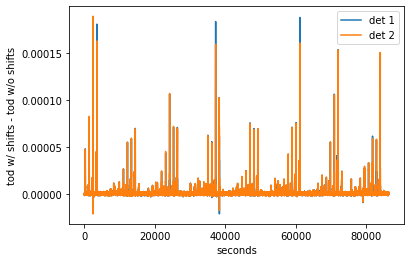

In [75]:
plt.plot(obs_sh.tod[0]-obs_w.tod[0], label = 'det 1')
plt.plot(obs_sh.tod[1]-obs_w.tod[1], label = 'det 2')
plt.legend()
plt.xlabel('seconds')
plt.ylabel('tod w/ shifts - tod w/o shifts')

There is overall a ~ percent difference between the two. The difference is due to the foregrounds, which are frequency dependent, and the interplay with chromatic HWP non-idealities

## To make a map

In [33]:
obs, = sim.create_observations(detectors=dets)

pointings = lbs.scanning.get_pointings(obs,
                                       spin2ecliptic_quats=sim.spin2ecliptic_quats,
                                       detector_quats=detquats,
                                       bore2spin_quat=instrumentinfo.bore2spin_quat,
                                      )

In [34]:
sim.parameter_file = par   #setting the parameter file
hwp_sys_band = lbs.HwpSysAndBandpass(sim)

In [35]:
hwp_sys_band.set_parameters(#maps=maps,    # ---> to use without band integration
                       integrate_in_band=True,
                       correct_in_solver=True,
                       built_map_on_the_fly=True,
                       nside=nside,
                       bandpass_parameters={'low edge': 96,
                                            'high edge': 104,'alpha': 0.9}, #100GHz band
                       include_beam_throughput=False,
                       Mbsparams = Mbsparams,
                      Channel = channelinfo
                      )

[2022-03-08 11:58:04,030 INFO MPI#0000] using the passed instrument to generate maps
[2022-03-08 11:58:04,034 INFO MPI#0000] generating and saving cmb simulations
[2022-03-08 11:58:04,045 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-03-08 11:58:04,049 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-03-08 11:58:04,049 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from tutorial/cmb/0000/cmb_0000_date_220308.fits
  warnings.warn(f"Access data from {full_path}")
[2022-03-08 11:58:04,117 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-03-08 11:58:04,119 INFO MPI#0000] NSIDE = 64
[2022-03-08 11:58:04,119 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-08 11:58:04,120 INFO MPI#0000] INDXSC

***************** D
***************** D
***************** D


/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-03-08 11:58:04,364 INFO MPI#0000] NSIDE = 512
[2022-03-08 11:58:04,364 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-08 11:58:04,365 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-03-08 11:58:04,477 INFO MPI#0000] NSIDE = 512
[2022-03-08 11:58:04,478 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-08 11:58:04,478 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/ff_t_new.fits (if not cach

In [36]:
hwp_sys_band.fill_tod(obs,pointings,hwp_radpsec)

In [37]:
maps = hwp_sys_band.make_map([obs])

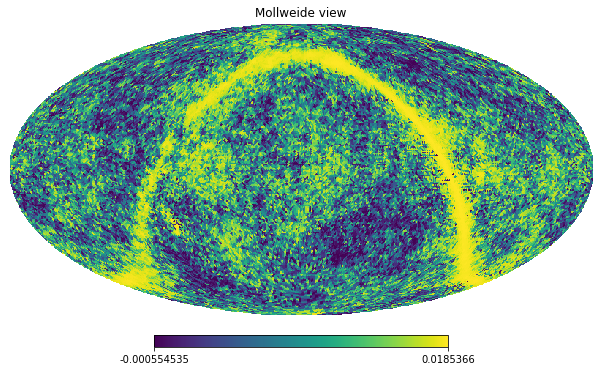

In [38]:
hp.mollview(maps[0], norm = 'hist')

let's try to subtract to that the input maps, integrated in band like the tod:

In [39]:
int_maps = np.zeros_like(hwp_sys_band.maps)
for i in range(int_maps.shape[0]):
    int_maps[i] = hwp_sys_band.cmb2bb[i]*hwp_sys_band.maps[i]

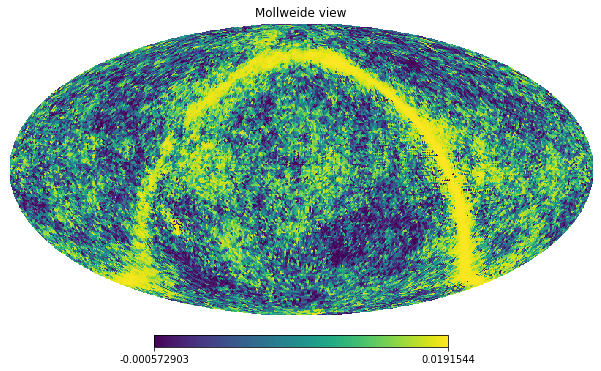

In [43]:
summed_maps = int_maps.sum(axis = 0)
hp.mollview(summed_maps[0], norm = 'hist')

The difference between the output and the integral in frequency of band * input map is not null because of the chromaticity of FG and HWP+bandpass parameters coupled to the mapmaking procedure

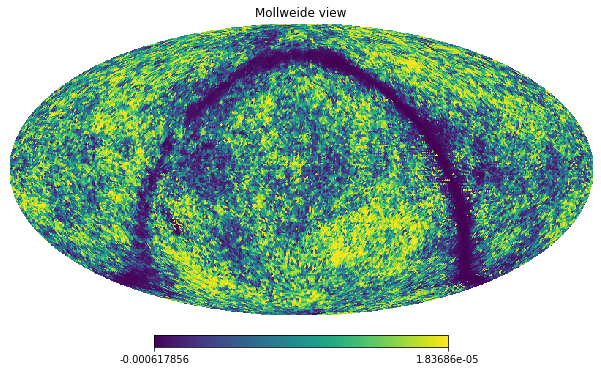

In [45]:
hp.mollview(maps[0]-summed_maps[0], norm = 'hist')